In [47]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Reshape

In [2]:
df = pd.read_csv('../data/by_quarter_nan_0_terciaria.csv')

## Vamos a predecir los cuatro cuartos de la hora con los datos de dos horas antes :P
Es decir:
Target 10394, 10395 para H+q*i i = 0,1,2,3; q = 0.25
Datos: H - 2 + j; j = 0:23

In [17]:
df.set_index('datetime',inplace=True)

In [21]:
scaler = MinMaxScaler()
df.loc[:] = scaler.fit_transform(df)

In [44]:
def create_sequences(df, sequence_length):
    X, y = [], []
    for i in range(0,len(df) - sequence_length - 4, 4):
        X.append(df.iloc[i:i+sequence_length])
        y.append(df.iloc[i+sequence_length:i+sequence_length+4][['target1','target2']])
    return np.array(X), np.array(y)

sequence_length = 24*4
X, y = create_sequences(df, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [48]:
model = Sequential([
    # First LSTM layer with return_sequences=True to keep the sequence across timesteps
    LSTM(50, activation='relu', return_sequences=True, input_shape=(96, 58)),
    
    # Second LSTM layer with return_sequences=False (this reduces the output to the last hidden state)
    LSTM(50, activation='relu', return_sequences=False),
    
    # Fully connected (Dense) layer that outputs the desired sequence length (4 timesteps) with 2 features each
    Dense(4 * 2),  # 4 timesteps * 2 features
    
    # Reshape the final output into the shape (4, 2)
    Reshape((4, 2))
])

model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()


/home/aner/.venvs/energy/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 96, 50)         │        21,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 2)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,408 (165.66 KB)

 Trainable params: 42,408 (165.66 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - loss: 0.0097 - val_loss: 0.0084
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 8/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 9/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 10/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 11/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 12/25
375/375 ━━━━━━━━━━

In [50]:
y_pred = model.predict(X_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [55]:
loss = model.evaluate(X_test,y_test,verbose=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0067


In [60]:
import matplotlib.pyplot as plt

In [67]:
y_pred_flat = y_pred.reshape(-1,2)
y_test_flat = y_test.reshape(-1,2)

In [77]:
idx = df.index[:n_obs]

In [78]:
n_obs = y_pred_flat.shape[0]

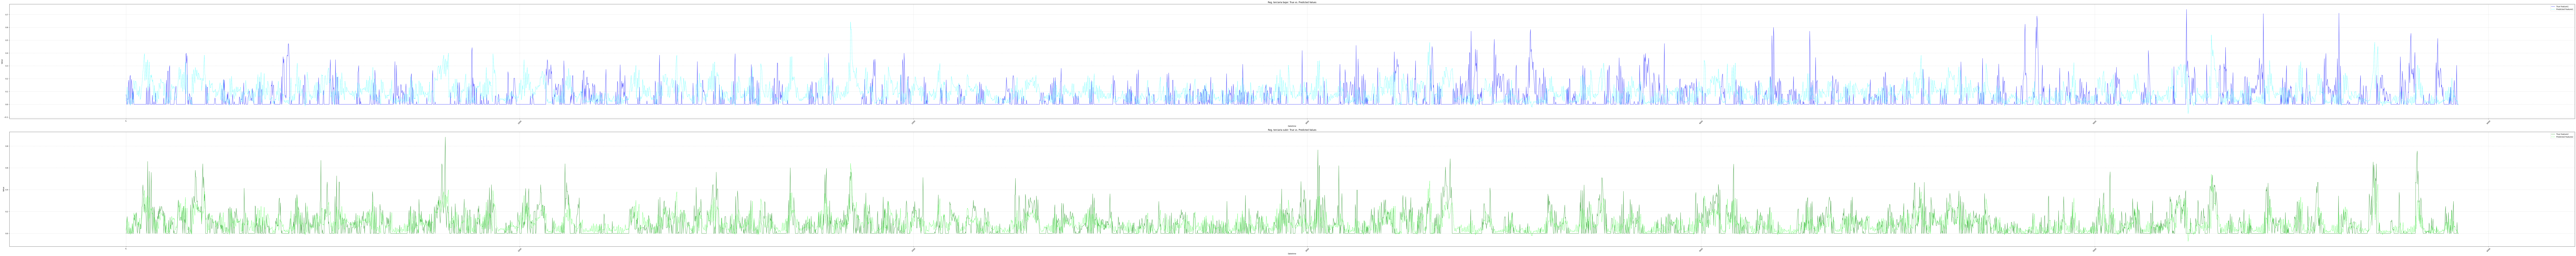

In [83]:
plt.figure(figsize=(200, 20))  # Increase figure size for better visibility

# Plot for Feature1
plt.subplot(2, 1, 1)
plt.plot(y_test_flat[:,0], label='True Feature1', color='blue', linestyle='-', alpha=0.7)
plt.plot(y_pred_flat[:,1], label='Predicted Feature1', color='cyan', linestyle='--', alpha=0.7)
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title('Reg. terciaria bajar: True vs. Predicted Values')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)

# Plot for Feature2
plt.subplot(2, 1, 2)
plt.plot(y_test_flat[:,1], label='True Feature2', color='green', linestyle='-', alpha=0.7)
plt.plot(y_pred_flat[:,1], label='Predicted Feature2', color='lime', linestyle='--', alpha=0.7)
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title('Reg. terciaria subir: True vs. Predicted Values')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [87]:
nonzero_simultaneous = df[(df['target1'] != 0) & (df['target2'] != 0)]

# Count the number of such instances
count_nonzero_simultaneous = nonzero_simultaneous.shape[0]
print(count_nonzero_simultaneous)

58
